In [ ]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tools
from scipy.constants import c, nu2lambda

In [158]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png{
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [159]:
figsize(8,4)

In [160]:
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python')
sys.path.append('C:\\Program Files\\Lumerical\\v221\\api\\python\\lumapi.py')

In [161]:
warnings.filterwarnings("ignore", category=SyntaxWarning)
import lumapi
fdtdApi = lumapi.FDTD()

In [162]:
fdtdApi.switchtolayout()
fdtdApi.deleteall()

In [163]:
#units
nm = 1e-9
um = 1e-6

In [164]:
# Parametros do acoplador direcional
lc = 38.188*um
gap = 200*nm
rad = 5*um
# Parametros do guia de onda
wg_width = 500*nm
wg_height = 220*nm
# Materiais do guia de onda
material_Clad = 'SiO2 (Glass) - Palik'
material_core = 'Si (Silicon) - Palik'

In [165]:
#Banda de operação (banda C)
wl_start = 1530*nm
wl_stop = 1565*nm
nbmFrqPnts = 21
# Nome do arquivo
filename = 'dc_FDTd_%d_nm_%03d_um'%(gap/nm,lc/um) 

In [166]:
## Configuração do FDTD
# Tempo de simulação
simulation_time = (np.pi*rad+lc)*7/c+200e-15

# Dimensões da porta
portSize = 2*um
portBcDist = 6*um
# Dimensões do volume do solver
x_FDTD = lc/2 + 2*rad
y_FDTD = -rad-gap/2-wg_height
x_span_FDTD = lc+2*rad+portBcDist
y_span_FDTD = 2*rad + gap + 2*wg_width+portSize
z_span_FDTD = 5*um
# Material
backGroundMaterial = material_Clad
# Precisão do mesh
mesh_accuracy = 3
# condições de fronteira
z_min_bc = 'Symmetric'

In [167]:
# Parametrosa das portas
y_port_off = 0.5*um
x_port = np.array([lc+3*rad, rad, lc+3*rad, rad])
y_port = np.array([-(2*rad+gap+wg_width+y_port_off),-(2*rad+gap+wg_width+y_port_off),0+y_port_off,0+y_port_off])
x_span_port = 4*um
z_span_port = 4*um
mode_selection = 'fundamental TE mode'
injection_axis = 'y-axis'

## Criando dispositivo

In [168]:
for i in range(4):
    fdtdApi.addobject('90_bend_wg')
    fdtdApi.set('name',f'arco{i}')
    fdtdApi.set('material',material_core)
    fdtdApi.set('base width',wg_width)
    fdtdApi.set('base height',wg_height)
    fdtdApi.set('start angle', i*90)
    fdtdApi.set('radius',rad)
    fdtdApi.set('z',0)
    
fdtdApi.setnamed('arco0', 'x', 2*rad + lc)
fdtdApi.setnamed('arco1', 'x', 2*rad)
fdtdApi.setnamed('arco2', 'x', 2*rad)
fdtdApi.setnamed('arco3', 'x', 2*rad + lc)

fdtdApi.setnamed('arco0', 'y', -(gap+wg_width+2*rad))
fdtdApi.setnamed('arco1', 'y', -(gap+wg_width+2*rad))
fdtdApi.setnamed('arco2', 'y', 0)
fdtdApi.setnamed('arco3', 'y', 0)

for i in range(4):
    fdtdApi.addrect()
    fdtdApi.set('name',f'port{i}')
    fdtdApi.set('material',material_core)
    fdtdApi.set('x span',wg_width)
    fdtdApi.set('y span',portSize)
    fdtdApi.set('z span',wg_height)
    fdtdApi.set('z',0)
    
fdtdApi.setnamed('port0', 'y', -(portSize/2 + 2*rad+gap+wg_width))
fdtdApi.setnamed('port0', 'x', lc+3*rad)
fdtdApi.setnamed('port1', 'y', -(portSize/2 + 2*rad+gap+wg_width))
fdtdApi.setnamed('port1', 'x', rad)

fdtdApi.setnamed('port2', 'y', portSize/2)
fdtdApi.setnamed('port2', 'x', lc+3*rad)
fdtdApi.setnamed('port3', 'y', portSize/2)
fdtdApi.setnamed('port3', 'x', rad)

fdtdApi.addrect()
fdtdApi.set('name','wav01')
fdtdApi.set('material',material_core)
fdtdApi.set('x', 2*rad + lc/2)
fdtdApi.set('x span',lc)
fdtdApi.set('y', -rad)
fdtdApi.set('y span',wg_width)
fdtdApi.set('z',0)
fdtdApi.set('z span',wg_height)

fdtdApi.addrect()
fdtdApi.set('name','wav02')
fdtdApi.set('material',material_core)
fdtdApi.set('x', 2*rad + lc/2)
fdtdApi.set('x span',lc)
fdtdApi.set('y', -rad-gap-wg_width)
fdtdApi.set('y span',wg_width)
fdtdApi.set('z',0)
fdtdApi.set('z span',wg_height)

## Adição do solver FDTD, porta e monitor

In [14]:
# solver
fdtdApi.addfdtd()
fdtdApi.set('x', x_FDTD)
fdtdApi.set('x span', x_span_FDTD)
fdtdApi.set('y', y_FDTD)
fdtdApi.set('y span', y_span_FDTD)
fdtdApi.set('z', 0)
fdtdApi.set('z span', z_span_FDTD)
fdtdApi.set('background material', backGroundMaterial)
fdtdApi.set('mesh accuracy', mesh_accuracy)
fdtdApi.set('simulation time', simulation_time)
fdtdApi.set('z min bc', z_min_bc)

In [15]:
# portas
for i in range(4):
    fdtdApi.addport()
    fdtdApi.set('name',f'port {i+1}')
    fdtdApi.set('x',x_port[i])
    fdtdApi.set('x span',x_span_port)
    fdtdApi.set('y',y_port[i])
    fdtdApi.set('z',0)
    fdtdApi.set('z span',z_span_port)
    fdtdApi.set('mode selection',mode_selection)
    fdtdApi.set('injection axis',injection_axis)
for i in range(4):
    fdtdApi.select(f'FDTD::ports::port {i+1}')
    fdtdApi.set('x span', 4*1e-6)
fdtdApi.setnamed('FDTD::ports::port 3','direction','Backward')
fdtdApi.setnamed('FDTD::ports::port 4','direction','Backward')

In [16]:
# configuração da banda de simulação
fdtdApi.setnamed('FDTD','global source wavelength start',wl_start)
fdtdApi.setnamed('FDTD','global source wavelength stop',wl_stop)
fdtdApi.setnamed('FDTD::ports','monitor frequency points',nbmFrqPnts)

In [17]:
# monitor de campo - lembrar de desativar para otimização
fdtdApi.addprofile()
fdtdApi.set('override global monitor settings', True)
fdtdApi.set('frequency points', nbmFrqPnts)
fdtdApi.set('x', x_FDTD)
fdtdApi.set('x span', x_span_FDTD)
fdtdApi.set('y', y_FDTD)
fdtdApi.set('y span', y_span_FDTD)
fdtdApi.set('z', 0)

In [18]:
# salvando arquivo
filename ='dc_FDTD_%d_nm_%03d_um'%(gap*nm,lc*1e7)
fdtdApi.save(filename)

In [19]:
#simulação
fdtdApi.run(3)

In [20]:
# importando campo elétrico
eField = np.abs(np.squeeze(fdtdApi.getelectric('monitor')))**2

In [21]:
# apresentação do campo eletrico obtido
indxLamda = 10
x_efielf = fdtdApi.getdata('monitor','x')
y_efielf = fdtdApi.getdata('monitor','y')
freq = fdtdApi.getdata('monitor','f')
lmbd = c/freq
xmin = um*np.min(x_efielf)
xmax = um*np.max(x_efielf)
ymin = um*np.min(y_efielf)
ymax = um*np.max(y_efielf)

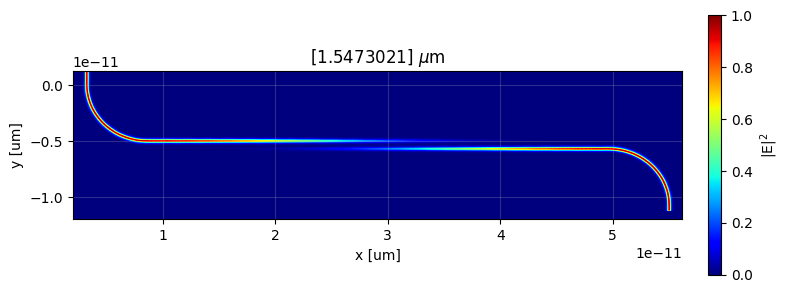

In [22]:
# Escala linear
fig1 = plt.figure(figsize=(8,8))
ax1 = fig1.add_subplot(111)

im1 = ax1.imshow(np.rot90(eField[:,:,indxLamda]),cmap= 'jet', extent=[xmin,xmax,ymin,ymax], vmin=0,vmax=1)

colorbar = plt.colorbar(im1, fraction=0.02, pad=0.04)
colorbar.set_label(r'|E|$^2$')
ax1.set_xlabel('x [um]')
ax1.set_ylabel('y [um]')
ax1.set_title(rf'{lmbd[indxLamda]/um} $\mu$m')
ax1.grid(which='major', alpha=0.25)
plt.savefig(f'efield {filename} linear.png', bbox_inches='tight', dpi=300)
plt.tight_layout()


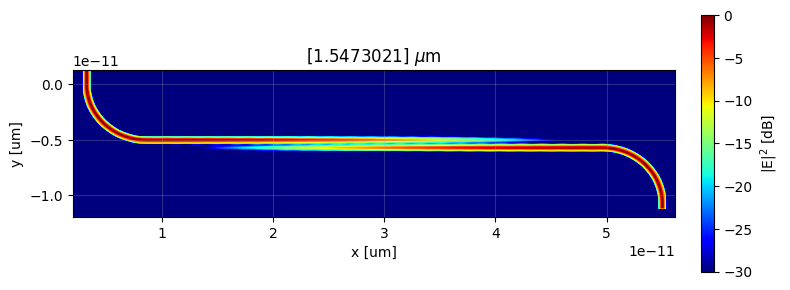

In [23]:
# Escala logarítmica
fig2 = plt.figure(figsize=(8,8))
ax2 = fig2.add_subplot(111)
im2 = ax2.imshow(10*np.log10(np.rot90(eField[:,:,indxLamda])),cmap= 'jet', extent=[xmin,xmax,ymin,ymax], vmin=-30,vmax=0)

colorbar = plt.colorbar(im2, fraction=0.02, pad=0.04)
colorbar.set_label(r'|E|$^2$ [dB]')

ax2.set_xlabel('x [um]')
ax2.set_ylabel('y [um]')
ax2.set_title(rf'{lmbd[indxLamda]/um} $\mu$m')
ax2.grid(which='major', alpha=0.25)

plt.tight_layout()
plt.savefig(f'efield {filename} log.png', bbox_inches='tight', dpi=300)

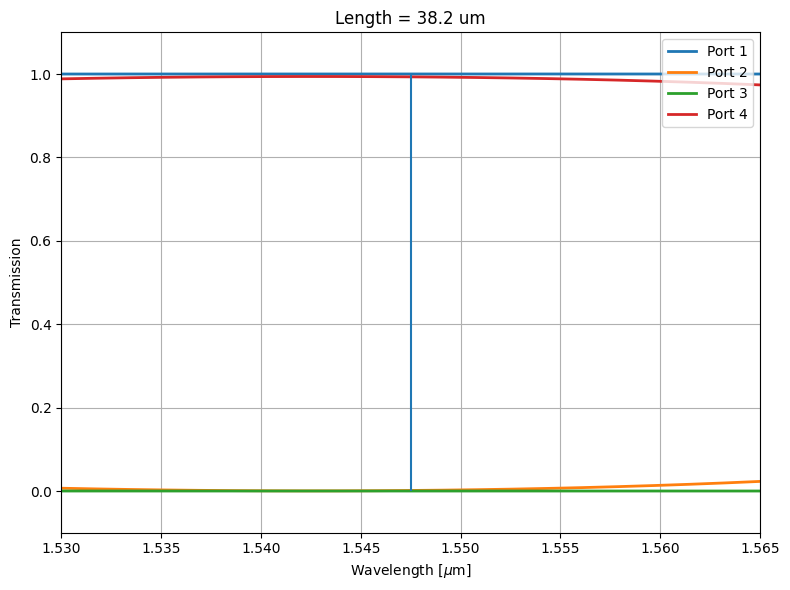

In [24]:
# Apresenta a transmissão do dispositivo em cada porta.
fig3 = plt.figure(figsize=(8,6))
for i in range(4):
    ports = fdtdApi.getresult("FDTD::ports::port %d" %(i+1), "T")
    plt.plot(1e6*ports['lambda'], np.abs(ports["T"]), label = "Port %d" %(i+1), linewidth = 2)

#plt.plot([lmbd[indxLamda]/um, lmbd[indxLamda]/um], [0,1.1], 'k--')
plt.vlines(1.5475,0,1)
plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Transmission")
plt.xlim([wl_start/um, wl_stop/um])
plt.ylim([-0.1,1.1])
plt.title(rf"Length = %.1f um" %(lc/um))
plt.grid(True)

plt.gca().set_xticks(np.arange(1.53, 1.565, 0.01), minor=True)
plt.gca().grid(which="minor", alpha=0.25)

plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('efield_' + filename + '_transmission.png', bbox_inches='tight')
plt.show()


## Variando o comprimento de acoplamento

In [25]:
import scipy

In [26]:
fdtdApi.switchtolayout()
fdtdApi.setnamed('monitor','enabled',1)

lc_start = 0*um
lc_stop = 39*um
lc_points = 20
lc = np.linspace(lc_start, lc_stop, lc_points)

In [120]:
ports = np.zeros([lc_points,4,nbmFrqPnts])

for i in range(len(lc)):
    lc_wav = lc[i]
    fdtdApi.switchtolayout()
    
    simulation_time = (np.pi*rad+lc_wav)*7/c+200e-15
    fdtdApi.setnamed('FDTD','simulation time',simulation_time)
    
    fdtdApi.setnamed('arco0','x',2*rad + lc_wav)
    fdtdApi.setnamed('arco3','x',2*rad + lc_wav)
    
    if (lc_wav == 0):
        fdtdApi.setnamed('wav01', 'enabled',0)
        fdtdApi.setnamed('wav02', 'enabled',0)  
    else:
        fdtdApi.setnamed('wav01', 'enabled',1)
        fdtdApi.setnamed('wav02', 'enabled',1)
        fdtdApi.setnamed('wav01','x',2*rad + lc_wav/2)
        fdtdApi.setnamed('wav01','x span',lc_wav)
        fdtdApi.setnamed('wav02','x',2*rad + lc_wav/2)
        fdtdApi.setnamed('wav02','x span',lc_wav)
    
    fdtdApi.setnamed('FDTD::ports::port 1','x',lc_wav+3*rad)
    fdtdApi.setnamed('FDTD::ports::port 3','x',lc_wav+3*rad)
    
    fdtdApi.setnamed('FDTD', 'x', lc_wav/2 + 2*rad)
    fdtdApi.setnamed('FDTD', 'x span', lc_wav + 2*rad + portBcDist)
    
    fdtdApi.setnamed('monitor','x', lc_wav/2 + 2*rad)
    fdtdApi.setnamed('monitor','x span', lc_wav + 2*rad + portBcDist)
    
    filename = f'DC_FDTD_cBand_{gap/nm}_nm_{lc_wav/um}um'
    fdtdApi.save(filename)
    fdtdApi.run(3)
    
    for j in range(4):
        ports[i,j,:] = fdtdApi.getresult(f"FDTD::ports::port {j+1}", "T")["T"]

In [122]:
wvl = fdtdApi.getresult('FDTD::ports::port 1', 'T')['lambda']

In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig,ax = plt.subplots(figsize=(8,6))
for i in range(6,15):
    ax.plot(lc/um, np.abs(ports[:,3,i]), label = rf'{(wvl[i]/um).item():.2f} $\mu$m', linewidth = 2)
    
ax.set_xlabel("Coupling length [um]")
ax.set_ylabel("Transmission")
ax.set_xlim([lc_start/um, lc_stop/um])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)

axins = zoomed_inset_axes(ax,2,loc=7,bbox_to_anchor=[550,200],borderpad=3)

for i in range(6,15):
    axins.plot(lc/um, np.abs(ports[:,3,i]),'o-' ,label = rf'{(wvl[i]/um).item():.2f} $\mu$m', linewidth = 2)
axins.set_xlim(9, 12)
axins.set_ylim(0.4, 0.6)

axins.yaxis.get_major_locator().set_params(nbins=4)
axins.xaxis.get_major_locator().set_params(nbins=4)
axins.grid()

mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.tight_layout()
plt.savefig('acoplamento_versus_lambda.png', bbox_inches='tight')

NameError: name 'plt' is not defined

## Tamanho otimizado

In [27]:
lc_wav = 19.1*um
fdtdApi.switchtolayout()

simulation_time = (np.pi*rad+lc_wav)*7/c+200e-15
fdtdApi.setnamed('FDTD','simulation time',simulation_time)

fdtdApi.setnamed('arco0','x',2*rad + lc_wav)
fdtdApi.setnamed('arco3','x',2*rad + lc_wav)

fdtdApi.setnamed('wav01', 'enabled',1)
fdtdApi.setnamed('wav02', 'enabled',1)
fdtdApi.setnamed('wav01','x',2*rad + lc_wav/2)
fdtdApi.setnamed('wav01','x span',lc_wav)
fdtdApi.setnamed('wav02','x',2*rad + lc_wav/2)
fdtdApi.setnamed('wav02','x span',lc_wav)

fdtdApi.setnamed('port0','x',lc_wav+3*rad)
fdtdApi.setnamed('port2','x',lc_wav+3*rad)

fdtdApi.setnamed('FDTD::ports::port 1','x',lc_wav+3*rad)
fdtdApi.setnamed('FDTD::ports::port 3','x',lc_wav+3*rad)

fdtdApi.setnamed('FDTD', 'x', lc_wav/2 + 2*rad)
fdtdApi.setnamed('FDTD', 'x span', lc_wav + 2*rad + portBcDist)

fdtdApi.setnamed('monitor','x', lc_wav/2 + 2*rad)
fdtdApi.setnamed('monitor','x span', lc_wav + 2*rad + portBcDist)

In [28]:
filename = f'DC_FDTD_cBand_{gap/nm}_nm_{lc_wav/um}um'
fdtdApi.save(filename)
fdtdApi.run(3)

In [29]:
ports_opt = np.zeros((nbmFrqPnts,4))
for i in range(4):
    ports_opt[:,i] = fdtdApi.getresult(f"FDTD::ports::port {i+1}", "T")["T"]
wvl_opt = fdtdApi.getresult('FDTD::ports::port 1', 'T')['lambda']

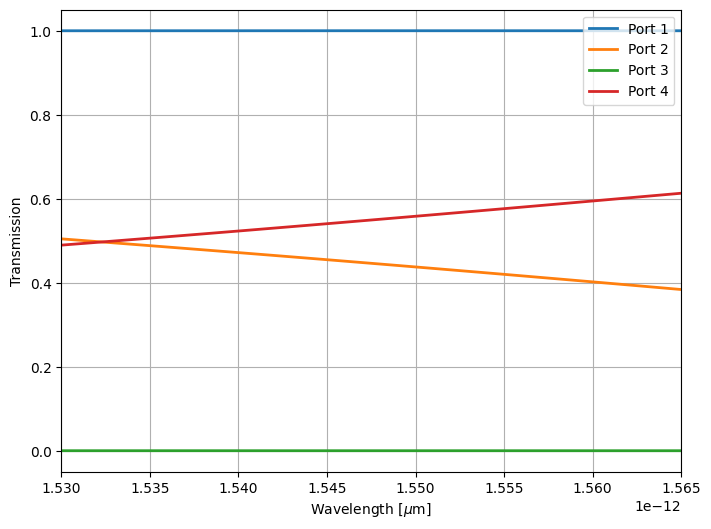

In [39]:
fig = plt.figure(figsize=(8,6))
for i in range(4):
    plt.plot(wvl_opt*um, np.abs(ports_opt[:,i]), label = "Port %d" %(i+1), linewidth = 2)

plt.xlabel("Wavelength [$\mu$m]")
plt.ylabel("Transmission")
plt.xlim([wl_start*um, wl_stop*um])
plt.grid(True)
plt.legend(loc='upper right')
plt.savefig('dc_05_otimizado.png', bbox_inches='tight')